## Import Libraries

In [1015]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics

%matplotlib inline

## Load the Data

In [1016]:
df = pd.read_csv("final_data_cleaned.csv")

In [1017]:
df.shape

(6397, 19)

In [1018]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,8,Manchester United,Defender Centre-Back,186.0,21.0,34.0,0.000000,0.000000,0.130529,0.0,0.0,0.0,0.0,2758.0,47.0,13.0,0.0,2000000.0,2000000.0
1,10,Manchester United,Defender Left-Back,169.0,23.0,89.0,0.012619,0.063096,0.227145,0.0,0.0,0.0,0.0,7132.0,182.0,15.0,3.0,22000000.0,22000000.0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [1019]:
# uniqeness
df[df.duplicated()]

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [1020]:
# Completeness
df.isnull().sum()

Unnamed: 0             0
team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [1021]:
# Accurecy types
df.dtypes

Unnamed: 0               int64
team                    object
position                object
height                 float64
age                    float64
appearance             float64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played         float64
days_injured           float64
games_injured          float64
award                  float64
current_value          float64
highest_value          float64
dtype: object

In [1022]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
numerical_feats_2 = ['height', 'age', 'appearance', 'goals', 'assists',
       'yellow cards', 'second yellow cards', 'red cards', 'goals conceded',
       'clean sheets', 'minutes played', 'days_injured', 'games_injured',
       'award', 'current_value', 'highest_value']

cetegorical_feats_2 = ['team', 'position']

In [1023]:
# looping through the categorical columns and counting them
# if a category is only 1, we will treat it as an outlier
for i in cetegorical_feats_2:
    print(df[i].value_counts())

team
Huddersfield Town    29
Orlando Pirates      27
Cardiff City         26
Portimonense SC      26
Watford FC           26
                     ..
Bayern Munich         2
Gaziantep FK          2
Manchester City       2
FC Barcelona          2
Real Madrid           1
Name: count, Length: 374, dtype: int64
position
Defender Centre-Back          1247
midfield-CentralMidfield       767
Attack Centre-Forward          667
midfield-DefensiveMidfield     616
Defender Right-Back            582
Defender Left-Back             566
Attack-RightWinger             469
midfield-AttackingMidfield     466
Attack-LeftWinger              427
Goalkeeper                     423
midfield-LeftMidfield           65
midfield-RightMidfield          61
Attack-SecondStriker            36
midfield                         3
Defender                         1
Attack                           1
Name: count, dtype: int64


In [1024]:
# Calculate the frequency of each 'Type'
type_counts = df['team'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['team'].isin(type_counts[type_counts >= 2].index)]

In [1025]:
# Calculate the frequency of each 'Type'
type_counts = df['position'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['position'].isin(type_counts[type_counts >= 2].index)]

In [1026]:
# looping through the categorical columns and counting them
# if a category is only 1, we will treat it as an outlier
for i in cetegorical_feats_2:
    print(df[i].value_counts())

team
Huddersfield Town    29
Orlando Pirates      27
Watford FC           26
Blackpool FC         26
Portimonense SC      26
                     ..
Arsenal FC            4
Gaziantep FK          2
Bayern Munich         2
Manchester City       2
FC Barcelona          2
Name: count, Length: 373, dtype: int64
position
Defender Centre-Back          1247
midfield-CentralMidfield       767
Attack Centre-Forward          666
midfield-DefensiveMidfield     616
Defender Right-Back            582
Defender Left-Back             566
Attack-RightWinger             469
midfield-AttackingMidfield     466
Attack-LeftWinger              427
Goalkeeper                     423
midfield-LeftMidfield           65
midfield-RightMidfield          61
Attack-SecondStriker            36
midfield                         3
Name: count, dtype: int64


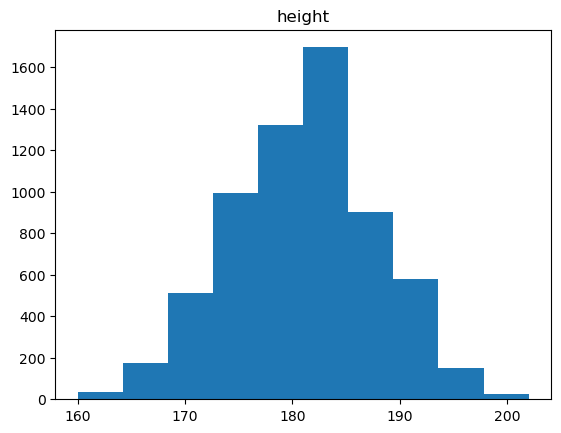

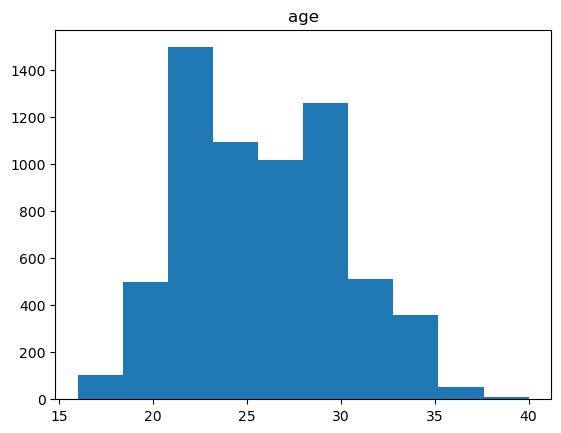

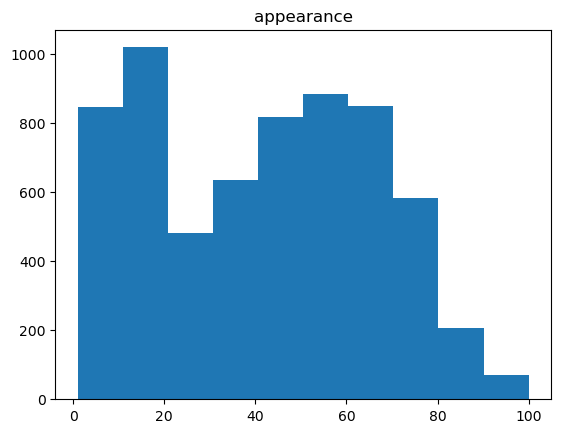

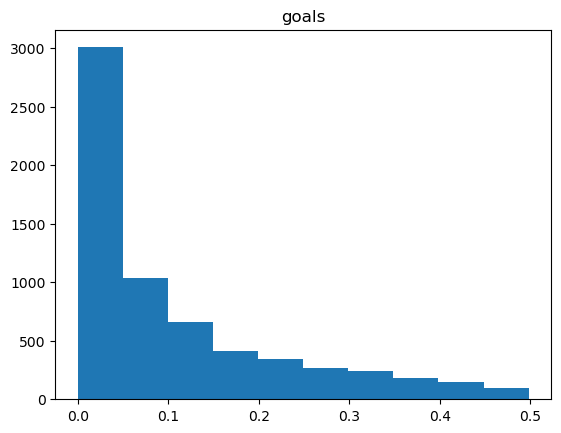

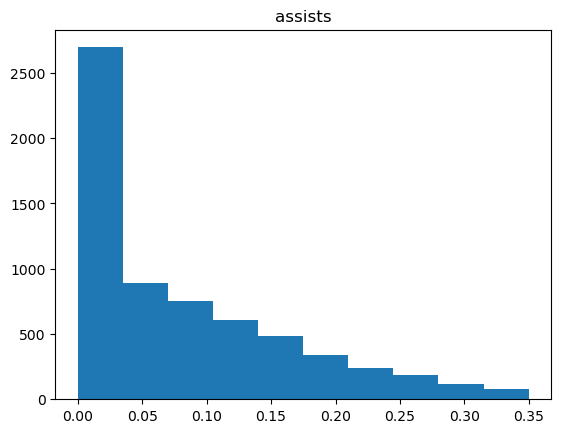

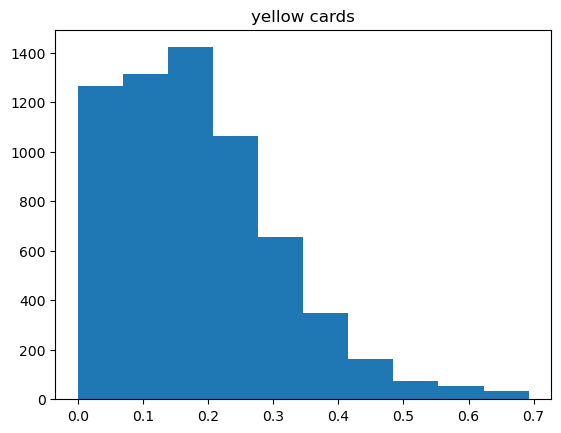

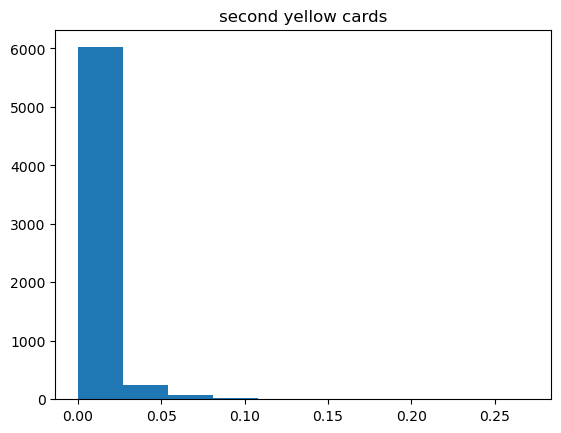

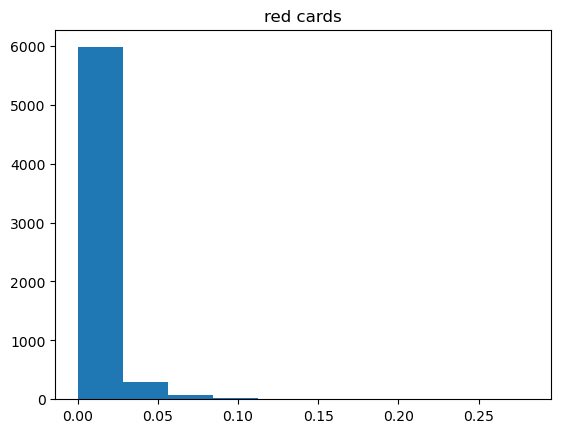

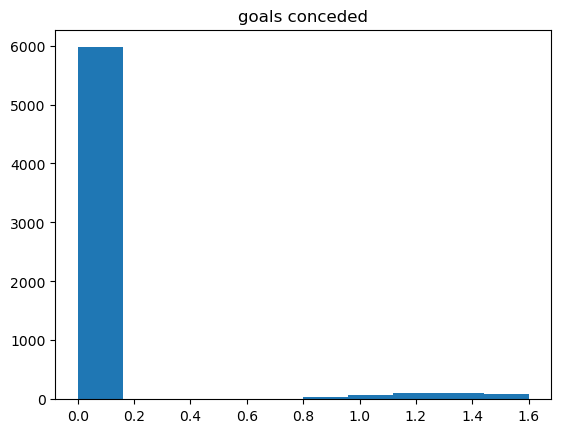

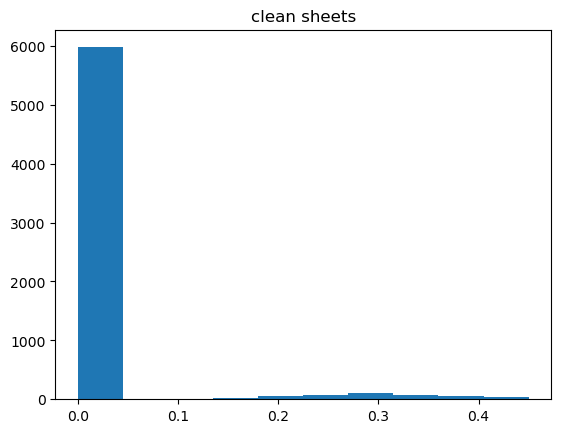

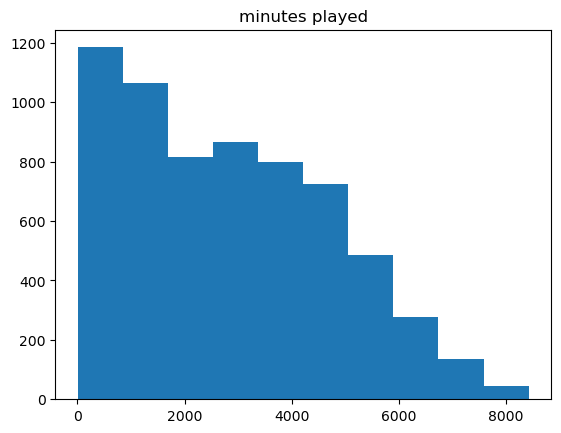

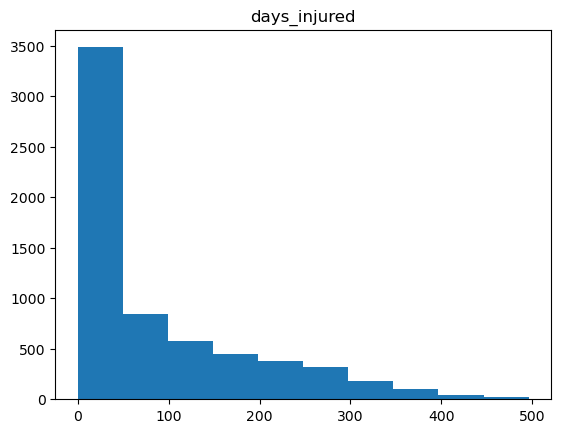

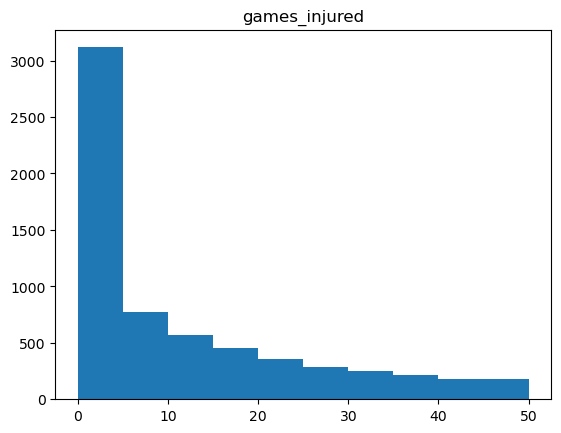

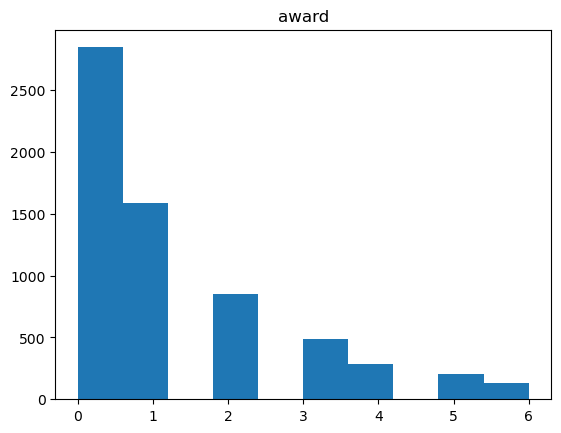

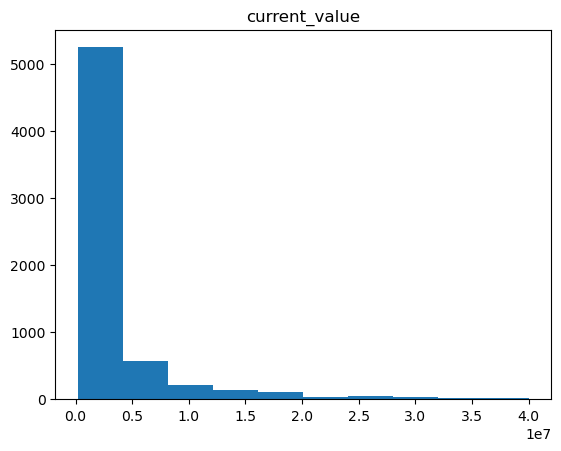

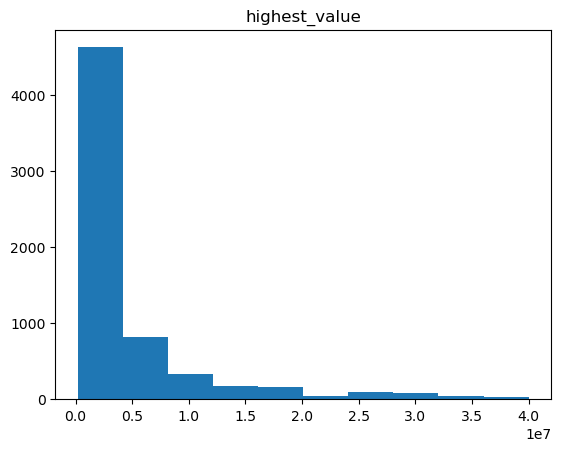

In [1027]:
# looping through the numerical columns and plotting them
# to help detect outliers
for i in numerical_feats_2:
    plt.hist(df[i]);
    plt.title(i)
    plt.show()

In [1028]:
df.columns

Index(['Unnamed: 0', 'team', 'position', 'height', 'age', 'appearance',
       'goals', 'assists', 'yellow cards', 'second yellow cards', 'red cards',
       'goals conceded', 'clean sheets', 'minutes played', 'days_injured',
       'games_injured', 'award', 'current_value', 'highest_value'],
      dtype='object')

In [1029]:
# removing the unnamed column
df.drop(columns='Unnamed: 0', inplace=True)

In [1030]:
df.columns

Index(['team', 'position', 'height', 'age', 'appearance', 'goals', 'assists',
       'yellow cards', 'second yellow cards', 'red cards', 'goals conceded',
       'clean sheets', 'minutes played', 'days_injured', 'games_injured',
       'award', 'current_value', 'highest_value'],
      dtype='object')

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [1031]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,Manchester United,Defender Centre-Back,186.0,21.0,34.0,0.000000,0.000000,0.130529,0.0,0.0,0.0,0.0,2758.0,47.0,13.0,0.0,2000000.0,2000000.0
1,Manchester United,Defender Left-Back,169.0,23.0,89.0,0.012619,0.063096,0.227145,0.0,0.0,0.0,0.0,7132.0,182.0,15.0,3.0,22000000.0,22000000.0


In [1033]:
cetegorical_feats_2

['team', 'position']

In [1034]:
df.shape

(6394, 18)

In [1035]:
# one hot coding
df = pd.get_dummies(df, columns=cetegorical_feats_2)

In [1036]:
df.shape

(6394, 403)

In [1037]:
df.head(2)

,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,...,position_Defender Centre-Back,position_Defender Left-Back,position_Defender Right-Back,position_Goalkeeper,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,186.0,21.0,34.0,0.000000,0.000000,0.130529,0.0,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
1,169.0,23.0,89.0,0.012619,0.063096,0.227145,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False


#### 3. Feature selection

In [1039]:
correlation = df.corr()

In [1040]:
print(correlation['current_value'].sort_values(ascending=False))

current_value           1.000000
highest_value           0.866758
appearance              0.408822
minutes played          0.408235
team_Aston Villa        0.161310
                          ...   
team_Orlando Pirates   -0.029575
team_Gwangju FC        -0.029921
position_Goalkeeper    -0.031118
goals conceded         -0.032060
age                    -0.130595
Name: current_value, Length: 403, dtype: float64


In [1042]:
# Set the correlation threshold
threshold = 0.12  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
selected_features

Index(['age', 'appearance', 'assists', 'minutes played', 'games_injured',
       'award', 'current_value', 'highest_value', 'team_Aston Villa',
       'team_Atalanta BC', 'team_Chelsea FC', 'team_Newcastle United',
       'team_SSC Napoli', 'team_Southampton FC'],
      dtype='object')

In [1043]:
selected_features

Index(['age', 'appearance', 'assists', 'minutes played', 'games_injured',
       'award', 'current_value', 'highest_value', 'team_Aston Villa',
       'team_Atalanta BC', 'team_Chelsea FC', 'team_Newcastle United',
       'team_SSC Napoli', 'team_Southampton FC'],
      dtype='object')

In [1044]:
selected_features = ['age', 'assists', 'minutes played', 'games_injured', 'current_value', 'highest_value', 'team_Aston Villa',
       'team_Atalanta BC', 'team_Chelsea FC', 'team_Newcastle United',
       'team_SSC Napoli', 'team_Southampton FC']

In [1045]:
df = df[selected_features]
# df.drop(columns=['minutes played', 'days_injured'], inplace=True)
df.head()

,age,assists,minutes played,games_injured,current_value,highest_value,team_Aston Villa,team_Atalanta BC,team_Chelsea FC,team_Newcastle United,team_SSC Napoli,team_Southampton FC
0,21.0,0.000000,2758.0,13.0,2000000.0,2000000.0,False,False,False,False,False,False
1,23.0,0.063096,7132.0,15.0,22000000.0,22000000.0,False,False,False,False,False,False
2,22.0,0.033507,2686.0,28.0,10000000.0,12000000.0,False,False,False,False,False,False
3,24.0,0.048439,5574.0,49.0,35000000.0,35000000.0,False,False,False,False,False,False
4,25.0,0.018817,4783.0,20.0,22000000.0,40000000.0,False,False,False,False,False,False


In [1046]:
df.columns

Index(['age', 'assists', 'minutes played', 'games_injured', 'current_value',
       'highest_value', 'team_Aston Villa', 'team_Atalanta BC',
       'team_Chelsea FC', 'team_Newcastle United', 'team_SSC Napoli',
       'team_Southampton FC'],
      dtype='object')

#### 4. Prepare train and test data

In [1047]:
# Prepare data
X = df.drop(['current_value'], axis=1)
y = df['current_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1048]:
X.shape

(6394, 11)

## Buliding the Model

In [1049]:
# creating Linear Regression model
model = LinearRegression()

In [1050]:
# creating Ridge model
ridge_model = Ridge()  

In [1051]:
# creating Lasso model
lasso_model = Lasso()  

In [1052]:
# initializing grid search models
# assigning a list of alpha values to try
param_grid = {
    'alpha': [0, 0.0000003, 0.0002, 0.001, 0.01, 0.5, 1, 5]  
}

# creating the Grid Search with the Ridge Model
grid_search_ridge = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

# creating the Grid Search with the Lasso Model
grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

## Train the Model

In [1053]:
# Fit the Linear Regression model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

In [1054]:
# Fit the Ridge model on the training data
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [1055]:
# Fit the Lasso model on the training data
lasso_model.fit(X_train_scaled, y_train)

Lasso()

In [1056]:
# Fit the Grid Search Ridge model on the training data
grid_search_ridge.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0, 3e-07, 0.0002, 0.001, 0.01, 0.5, 1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

In [1057]:
# Fit the Grid Search Lasso model on the training data
grid_search_lasso.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0, 3e-07, 0.0002, 0.001, 0.01, 0.5, 1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

## Test the Model

In [1058]:
# Predict and evaluate the Linear Regression model
y_pred = model.predict(X_test_scaled)

In [1059]:
# Predict and evaluate the Ridge model
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [1060]:
# Predict and evaluate the Lasso model
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [1061]:
# Best hyperparameter for the ridge model
print("Best parameters found: ", grid_search_ridge.best_params_)

# Best Ridge model
best_ridge = grid_search_ridge.best_estimator_

Best parameters found:  {'alpha': 0}


In [1062]:
# Best hyperparameter for the lasso model
print("Best parameters found: ", grid_search_lasso.best_params_)

# Best lasso model
best_lasso = grid_search_lasso.best_estimator_

Best parameters found:  {'alpha': 0}


In [1063]:
# Predict and evaluate the Lasso model
y_pred_ridge_cv = best_ridge.predict(X_test_scaled)

In [1064]:
# Predict and evaluate the best Lasso model
y_pred_lasso_cv = best_lasso.predict(X_test_scaled)

## Interpretation of the Model

In [1065]:
model.coef_

array([-791033.62634094,  -21849.9664186 ,  573863.84325618,
       -292861.30985646, 4191721.80411054,  144599.80248272,
        174990.48501655,  147537.79130582,  104708.23437505,
        136630.15839176,  207651.22261653])

In [1069]:
# putting the coefficients of the Linear Regression model in a dataframe to view it
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-7.910336e+05
assists,-2.184997e+04
minutes played,5.738638e+05
games_injured,-2.928613e+05
highest_value,4.191722e+06
team_Aston Villa,1.445998e+05
team_Atalanta BC,1.749905e+05
team_Chelsea FC,1.475378e+05
team_Newcastle United,1.047082e+05
team_SSC Napoli,1.366302e+05


In [1070]:
print(model.intercept_) 

2997321.603128054


In [1071]:
# putting the coefficients of the Lasso model in a dataframe to view it
coeff_df = pd.DataFrame(lasso_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-7.910328e+05
assists,-2.184873e+04
minutes played,5.738628e+05
games_injured,-2.928602e+05
highest_value,4.191721e+06
team_Aston Villa,1.445988e+05
team_Atalanta BC,1.749895e+05
team_Chelsea FC,1.475369e+05
team_Newcastle United,1.047072e+05
team_SSC Napoli,1.366292e+05


In [1072]:
# putting the coefficients of the Best Lasso model in a dataframe to view it
coeff_df = pd.DataFrame(best_lasso.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-7.910336e+05
assists,-2.184997e+04
minutes played,5.738638e+05
games_injured,-2.928613e+05
highest_value,4.191722e+06
team_Aston Villa,1.445998e+05
team_Atalanta BC,1.749905e+05
team_Chelsea FC,1.475378e+05
team_Newcastle United,1.047082e+05
team_SSC Napoli,1.366302e+05


In [1073]:
# putting the coefficients of the Ridge model in a dataframe to view it
coeff_df = pd.DataFrame(ridge_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-7.909331e+05
assists,-2.172539e+04
minutes played,5.740812e+05
games_injured,-2.925807e+05
highest_value,4.190666e+06
team_Aston Villa,1.446947e+05
team_Atalanta BC,1.750677e+05
team_Chelsea FC,1.475977e+05
team_Newcastle United,1.047897e+05
team_SSC Napoli,1.367177e+05


In [1074]:
# putting the coefficients of the Best Ridge model in a dataframe to view it
coeff_df = pd.DataFrame(best_ridge.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-7.910336e+05
assists,-2.184997e+04
minutes played,5.738638e+05
games_injured,-2.928613e+05
highest_value,4.191722e+06
team_Aston Villa,1.445998e+05
team_Atalanta BC,1.749905e+05
team_Chelsea FC,1.475378e+05
team_Newcastle United,1.047082e+05
team_SSC Napoli,1.366302e+05


## Evaluating the Model 

1. Mean Square Error

In [1075]:
y_base = [y_train.mean()] * len(y_test)

In [1076]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 36330562505749.086


In [1077]:
# calculating the mean squared error for the linear regression model
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 5775062260235.308
Mean Squared Error for testing: 6001844931074.336


2. Mean Absolute Error

In [1078]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 3412855.404660746


In [1079]:
# calculating the mean absolute error for the linear regression model
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 1371734.6420958084
Mean Absolute Error for testing: 1421776.58995001


3. Root Mean Squared Error

In [1080]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 1847.3915136377416


In [1081]:
# calculating the root mean squared error for the linear regression model
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 2403135.9221307705
Root Mean Squared Error for testing: 2449866.308816531


4. R Square

In [1082]:
# R2 score for the linear regression model, both training and test sets
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.7804082638995964
R Square for testing: 0.8340726118895918


In [1083]:
# R2 score for the ridge model, both training and test sets
r2_score_train_ridge = r2_score(y_train, ridge_model.predict(X_train_scaled))
r2_score_test_ridge = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train_ridge}')
print(f'R Square for testing: {r2_score_test_ridge}')

R Square for training: 0.7804082312416792
R Square for testing: 0.8340726118895918


In [1084]:
# R2 score for the grid search ridge model, both training and test sets
r2_score_train_grid_ridge = r2_score(y_train, grid_search_ridge.predict(X_train_scaled))
r2_score_test_grid_ridge = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train_grid_ridge}')
print(f'R Square for testing: {r2_score_test_grid_ridge}')

R Square for training: 0.7804082638995964
R Square for testing: 0.8340726118895918


In [1085]:
# R2 score for the lasso model, both training and test sets
r2_score_train_lasso = r2_score(y_train, lasso_model.predict(X_train_scaled))
r2_score_test_lasso = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train_lasso}')
print(f'R Square for testing: {r2_score_test_lasso}')

R Square for training: 0.780408263899203
R Square for testing: 0.8340726118895918


In [1086]:
# R2 score for the grid search lasso model, both training and test sets
r2_score_train_grid_lasso = r2_score(y_train, grid_search_lasso.predict(X_train_scaled))
r2_score_test_grid_lasso = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train_grid_lasso}')
print(f'R Square for testing: {r2_score_test_grid_lasso}')

R Square for training: 0.7804082638995964
R Square for testing: 0.8340726118895918


#### Predictions vs. Real Values

In [1087]:
# using the linear regression model to predict, yhat
predictions = model.predict(X_test_scaled)
predictions

array([ 125640.26395355,  284702.54855378, 2275155.69845673, ...,
       1632747.10958502, 7156469.21243505, 2191581.66892746])

In [1088]:
# getting the target, y
Real_Values = np.array(y_test)
Real_Values

array([ 250000.,  300000., 1500000., ...,  900000., 8000000., 2300000.])

In [1089]:
# using the ridge model to predict, yhat_ridge
predictions_ridge = ridge_model.predict(X_test_scaled)
predictions_ridge

array([ 125860.15561905,  284824.06947174, 2274948.92311338, ...,
       1633309.32072568, 7155931.43107099, 2191481.37028288])

In [1090]:
# getting the target, y_ridge
Real_Values_ridge = np.array(y_test)
Real_Values_ridge

array([ 250000.,  300000., 1500000., ...,  900000., 8000000., 2300000.])

In [1091]:
# using the lasso model to predict, yhat_lasso
predictions_lasso = lasso_model.predict(X_test_scaled)
predictions_lasso

array([ 125639.49969885,  284702.03741141, 2275156.12465423, ...,
       1632745.31216211, 7156469.48716839, 2191581.81581187])

In [1092]:
# getting the target, y_lasso
Real_Values_lasso = np.array(y_test)
Real_Values_lasso

array([ 250000.,  300000., 1500000., ...,  900000., 8000000., 2300000.])

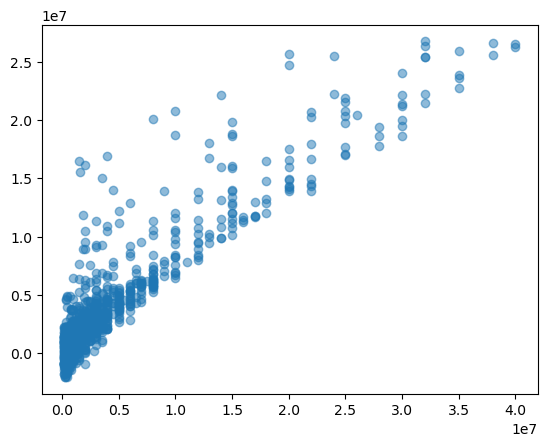

In [1093]:
# plotting the linear regression model
plt.scatter(Real_Values,predictions, alpha=0.5); 

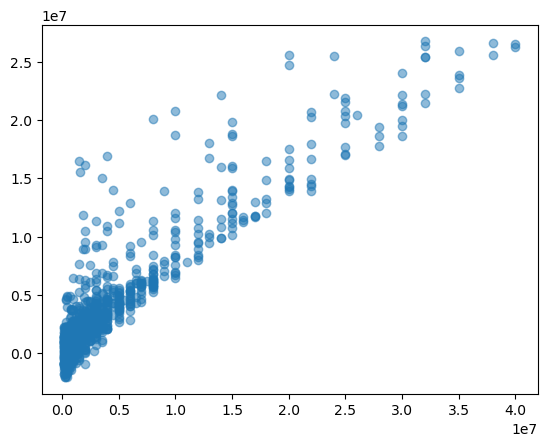

In [1094]:
# plotting the ridge model
plt.scatter(Real_Values_ridge, predictions_ridge, alpha=0.5); 

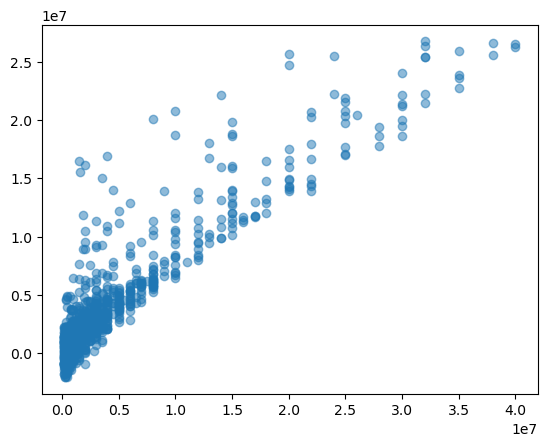

In [1095]:
# plotting the lasso model
plt.scatter(Real_Values_lasso, predictions_lasso, alpha=0.5); 

#### Residual Histogram

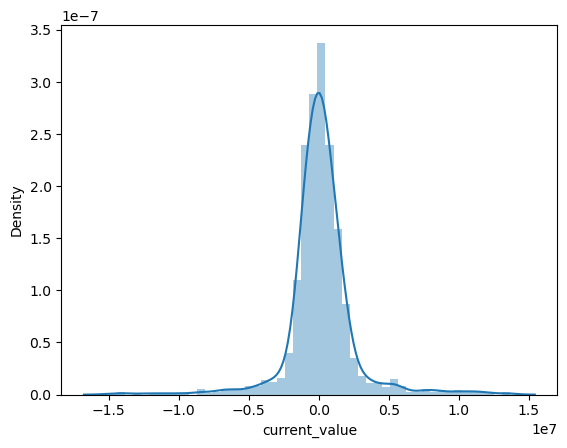

In [1096]:
# plotting the distribution of the Linear Regression model test predictions
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

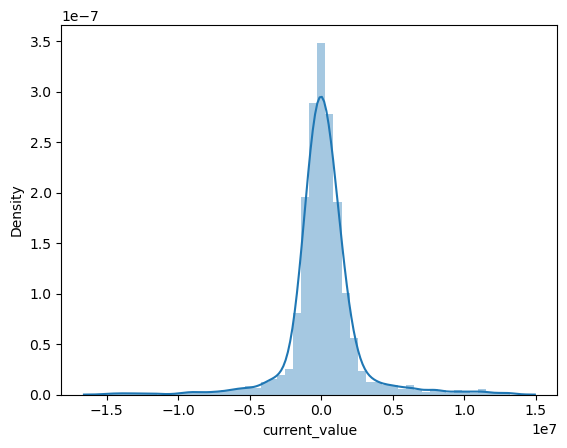

In [92]:
# plotting the distribution of the Lasso model test predictions
sns.distplot((y_test-predictions_lasso),bins=50);

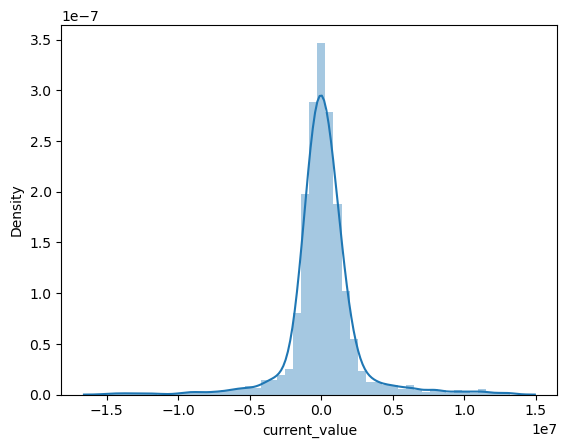

In [93]:
# plotting the distribution of the Ridge model test predictions
sns.distplot((y_test-predictions_ridge),bins=50);

### Cross-validation

In [1097]:
df.head()

,age,assists,minutes played,games_injured,current_value,highest_value,team_Aston Villa,team_Atalanta BC,team_Chelsea FC,team_Newcastle United,team_SSC Napoli,team_Southampton FC
0,21.0,0.000000,2758.0,13.0,2000000.0,2000000.0,False,False,False,False,False,False
1,23.0,0.063096,7132.0,15.0,22000000.0,22000000.0,False,False,False,False,False,False
2,22.0,0.033507,2686.0,28.0,10000000.0,12000000.0,False,False,False,False,False,False
3,24.0,0.048439,5574.0,49.0,35000000.0,35000000.0,False,False,False,False,False,False
4,25.0,0.018817,4783.0,20.0,22000000.0,40000000.0,False,False,False,False,False,False


In [1098]:
# Cross-validation score for the linear regression model

# Set up K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(r2_score))

# Output the results
print("R-squared scores for each fold:", scores)
print("Mean R-squared score:", np.mean(scores))
print("Standard deviation of R-squared scores:", np.std(scores))

R-squared scores for each fold: [0.83407261 0.79341267 0.80652551 0.77836458 0.72156265]
Mean R-squared score: 0.7867876065549354
Standard deviation of R-squared scores: 0.03740211212228731


In [1099]:
# Cross-validation score for the Ridge model

# Set up K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(ridge_model, X, y, cv=kf, scoring=make_scorer(r2_score))

# Output the results
print("R-squared scores for each fold:", scores)
print("Mean R-squared score:", np.mean(scores))
print("Standard deviation of R-squared scores:", np.std(scores))

R-squared scores for each fold: [0.83351904 0.79410718 0.80629856 0.77923377 0.72119882]
Mean R-squared score: 0.7868714729502362
Standard deviation of R-squared scores: 0.037355036525017045


In [1100]:
# Cross-validation score for the Lasso model

# Set up K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(lasso_model, X, y, cv=kf, scoring=make_scorer(r2_score))

# Output the results
print("R-squared scores for each fold:", scores)
print("Mean R-squared score:", np.mean(scores))
print("Standard deviation of R-squared scores:", np.std(scores))

R-squared scores for each fold: [0.83407182 0.79341353 0.80652507 0.77836578 0.72156174]
Mean R-squared score: 0.7867875876539907
Standard deviation of R-squared scores: 0.037402159559672174


In [1101]:
# Cross-validation score for the Best Ridge model

# Set up K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(best_ridge, X, y, cv=kf, scoring=make_scorer(r2_score))

# Output the results
print("R-squared scores for each fold:", scores)
print("Mean R-squared score:", np.mean(scores))
print("Standard deviation of R-squared scores:", np.std(scores))

R-squared scores for each fold: [0.83407261 0.79341267 0.80652551 0.77836458 0.72156265]
Mean R-squared score: 0.7867876065557432
Standard deviation of R-squared scores: 0.03740211212269603


In [1102]:
# Cross-validation score for the Best Lasso model

# Set up K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(best_lasso, X, y, cv=kf, scoring=make_scorer(r2_score))

# Output the results
print("R-squared scores for each fold:", scores)
print("Mean R-squared score:", np.mean(scores))
print("Standard deviation of R-squared scores:", np.std(scores))

R-squared scores for each fold: [0.83407261 0.79341267 0.80652551 0.77836458 0.72156265]
Mean R-squared score: 0.7867876065557431
Standard deviation of R-squared scores: 0.037402112122695924


In [94]:
residuals =  y_test - predictions

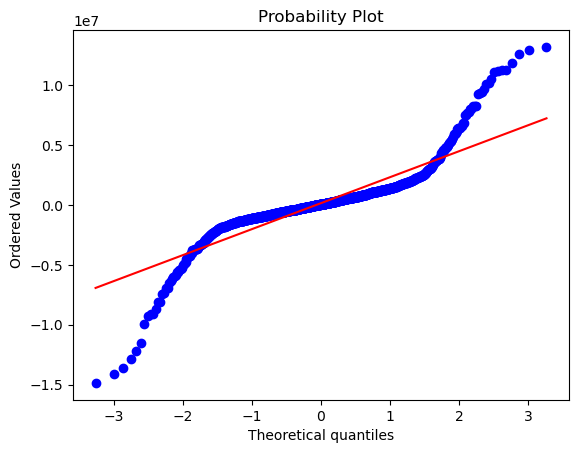

In [95]:
import pylab
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()